前面构建了一个最简单的神经网络 MLP（Multilayer Perceptron, 多层感知机），在CIFAR 10准确率在40-50%左右。

下面构建一个层数相同的卷积神经网络，进行对比

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class CNN(nn.Module):
  '''
  A ConvNet with two conv layers.
  '''
  def __init__(self, input_dim = (3,32,32), kernel_num = (24,12), output_dim = 10): # constructor
    super().__init__()
    self.layers = nn.Sequential(

        # in_channels (int) – Number of channels in the input image 
        # out_channels (int) – Number of channels produced by the convolution 
        # kernel_size (int or tuple) – Size of the convolving kernel 
        # stride (int or tuple, optional) – Stride of the convolution. Default: 1
        # padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0
        nn.Conv2d(input_dim[0], kernel_num[0], 3, 1, 1), # 内部运算时，三个in_channel的卷积后再累加，得到一个out_channel
        nn.ReLU(),
        nn.Conv2d(kernel_num[0], kernel_num[1], 3, 1, 1),
        nn.ReLU(),
        nn.Flatten(), # (start_dim=1, end_dim=-1),  
        nn.Linear(kernel_num[1]*input_dim[1]*input_dim[2], output_dim)
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

跟前面的MLP模型相比，CNN更好地捕获了像素之间的空间关系。

model is on: cuda:0



(dot.exe:18908): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


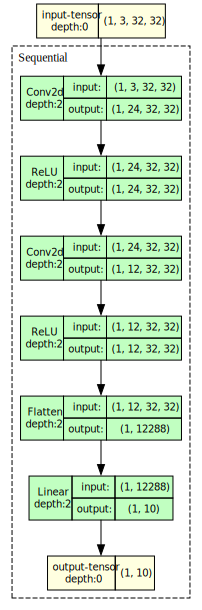

In [2]:
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

print('model is on:', next(model.parameters()).device)

model_graph = draw_graph(model, input_size=(1, 3, 32, 32), expand_nested=True) # device='meta', 
model_graph.visual_graph

## CIFAR 10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [3]:
# Prepare CIFAR-10 dataset
from torchvision.datasets import CIFAR10, CIFAR100

dataset = CIFAR10("../data/", download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)
dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()

pyTorch中的dataset类型（包括各种内置公开数据集和ImageFolder等返回的数据集对象），具有`classes`和`class_to_idx`两个属性，可以方便得到类别名称和字典

In [ ]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam - 某种梯度下降算法，此处不展开; lr - learning rate
model.train()

loss_history = []
acc_history = []

# Run the training loop
for epoch in range(0, 50):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0

    corrects = 0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        inputs, targets = data # X & y
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward() # 后向传播，计算所有参数的偏导数
        
        # Perform optimization
        optimizer.step() # 根据偏导数更新各个参数

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == targets.data)
        
        # Print statistics
        current_loss += loss.item()
        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            loss_history.append(current_loss / 500)
            current_loss = 0.0

    acc = corrects.double().item() / len(dataset)
    print('acc =', acc)
    acc_history.append(acc)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch    50: 0.091
Loss after mini-batch   100: 0.092
Loss after mini-batch   150: 0.093
Loss after mini-batch   200: 0.094
Loss after mini-batch   250: 0.093
Loss after mini-batch   300: 0.096
Loss after mini-batch   350: 0.094
acc = 0.67282
Starting epoch 2
Loss after mini-batch    50: 0.087
Loss after mini-batch   100: 0.087
Loss after mini-batch   150: 0.087
Loss after mini-batch   200: 0.088
Loss after mini-batch   250: 0.088
Loss after mini-batch   300: 0.093
Loss after mini-batch   350: 0.091
acc = 0.69126
Starting epoch 3
Loss after mini-batch    50: 0.081
Loss after mini-batch   100: 0.084
Loss after mini-batch   150: 0.084
Loss after mini-batch   200: 0.084
Loss after mini-batch   250: 0.086
Loss after mini-batch   300: 0.086
Loss after mini-batch   350: 0.083
acc = 0.70666
Starting epoch 4
Loss after mini-batch    50: 0.077
Loss after mini-batch   100: 0.080
Loss after mini-batch   150: 0.080
Loss after mini-batch   200: 0.084
Loss after mini

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [ ]:
plt.plot(acc_history)

In [ ]:
testset = CIFAR10("../data/", train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=1)
testset

In [ ]:
import matplotlib.pyplot as plt

def evaluate_rgb_images(model, dataloader, max_samples = 100):

    model.eval()    
    sample_cnt = 0
    correct = 0
    for inputs, labels in dataloader:
    
        if sample_cnt >= max_samples:
            break
        sample_cnt += len(labels)
        
        plt.figure(figsize=(10,len(inputs)/10+1))
        for idx, img  in enumerate(inputs):
            plt.subplot(int(len(inputs)/10)+1, 10, idx+1)       
            # x = img * STD[:, None, None] + MEAN[:, None, None]
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.axis('off')
        plt.show()
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        print('truth: \n', labels)
        print('prediction: \n', preds)
        correct += (preds == labels).float().sum()
        
    accuracy = 100 * correct / sample_cnt
    print('classification accuracy (%) =', accuracy.item())

In [ ]:
evaluate_rgb_images(model, trainloader, max_samples = 200)

1个epoch acc就超过了MLP。最终训练集acc达到 90%+  

In [ ]:
evaluate_rgb_images(model, testloader, max_samples = 200)

发现训练集和测试集上模型的表现差异过大，这意味着发生了过拟合。  

后续改进，解决过拟合现象：
1. 尝试添加正则化(weight_decay)
2. 尝试更大的batch_size
3. 划分验证集和early stop

In [ ]:
from datetime import datetime
ts = datetime.today().strftime('%Y%m%d%H')
MODEL_NAME = 'cnn_cifar10_'+ ts + '.pth'
torch.save(model, MODEL_NAME)